Challenge Set Benson
Topic:        Explore MTA turnstile data
Date:         07/11/2016
Name:         Matthew Mitchell

In [2]:
import csv
import datetime
import pandas as pd
import numpy as np
import requests
import re
import urllib2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

#Challenge 1

In [5]:
def mta_file2dict(mta_file):
    with open(mta_file,'rb') as csvfile:
        reader=csv.reader(csvfile)
        rows=[[cell.strip() for cell in row] for row in reader] #Remove whitespace

    rows.pop(0) #Remove 1st row which are essentially column names

    turnstile_dictionary = dict()
    for row in rows:
        key=tuple(row[:4])
        if not turnstile_dictionary.has_key(key): #Initiate key if it does not exist
            turnstile_dictionary[key]=[]
        turnstile_dictionary[key].append(row[4:]) #Append information from row to dictionary value
    return turnstile_dictionary

In [7]:
turnstile_dictionary=mta_file2dict('/Users/matthewmitchell/Downloads/turnstile_160625.txt')
print turnstile_dictionary.keys()[:5]

[('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'), ('N192', 'R336', '00-05-00', 'BEACH 60 ST'), ('PTH08', 'R540', '00-01-06', 'PATH WTC'), ('H016', 'R250', '00-00-02', 'GRAND ST'), ('A069', 'R044', '01-00-02', 'CHAMBERS ST')]


#Challenge 2 

In [145]:
def turnstile_dict_2_cumulative_datetime(turnstile_dictionary):
    datetime_cumulative = {turnstile: [(datetime.datetime.strptime(date + time,
                                                          '%m/%d/%Y%X'),
                                        int(in_cumulative))
                                       for _, _, date, time,
                                           _, in_cumulative, _ in rows]
                           for turnstile, rows in turnstile_dictionary.items()}
    return datetime_cumulative

In [146]:
datetime_cumulative=turnstile_dict_2_cumulative_datetime(turnstile_dictionary)

In [16]:
def cumulative_datetime_2_frequency(datetime_cumulative):
    datetime_count_times = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1],
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}
    return datetime_count_times

In [17]:
def remove_implausible_counts(datetime_counts):
    datetime_counts = {turnstile: [(time, count) for (time, count, _) in rows 
                                   if 0 <= count <= 5000]
                       for turnstile, rows in datetime_count_times.items()}
    return datetime_counts

In [20]:
datetime_count_times=cumulative_datetime_2_frequency(datetime_cumulative)
cleaned_turnstile_datetime_counts=remove_implausible_counts(datetime_count_times)

#Challenge 3

In [21]:
def turnstile_datetime_counts_2_turnstile_daily_counts(datetime_counts):
    turnstile_daily_tot={}
    for (k,v) in datetime_counts.items():
        temp_day={}
        for date, count in v:
            day=date.date()
            temp_day[day]=temp_day.get(day,0)+count
        turnstile_daily_tot[k]=sorted(temp_day.items())
    return turnstile_daily_tot

In [22]:
turnstile_daily_tot=turnstile_datetime_counts_2_turnstile_daily_counts(cleaned_turnstile_datetime_counts)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
turnstile_daily_tot[('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')][0][0]

datetime.date(2016, 6, 18)

#Challenge 4

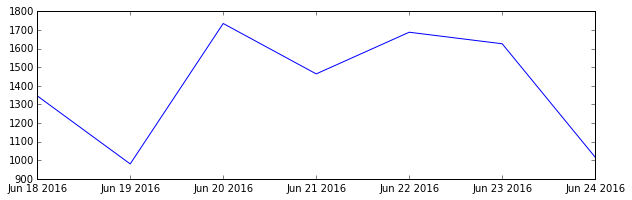

In [40]:
dates=[date for date, count in turnstile_daily_tot[('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')]]
counts=[count for date, count in turnstile_daily_tot[('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')]]
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

#Challenge 5

In [45]:
def turnstile_daily_tot_2_area_daily_tot(turnstile_daily_totals):
    area_daily_tot={}
    for turn_key, turnstile_value in turnstile_daily_totals.items(): #the turnstile value is a list [date object, entries]
        running_totals={}
        turnstile_daily_counts={}
        new_key=(turn_key[0],turn_key[1],turn_key[3]) #we only care about C/A, UNIT and STATION; SCP is discarded
        for date, count in area_daily_tot.get(new_key,[]): #Have we seen this (C/A,UNIT,STATION) key before?
            running_totals[date]=count #If so make a temporary dictionary for this (C/A,UNIT,STATION) that maps Dates to Entries
        for date, count in turnstile_value: #It's important to loop through the turnstile_value not prev_running_totals. Otherwise if we had not seen this (C/A,UNIT,STATION) key before, there would be no information to loop through and we would still have an empty list.
            running_totals[date]=running_totals.get(date,0)+count #This code could be consolidated to simply update running totals rather than introduce a second variable.
        area_daily_tot[new_key]=sorted(running_totals.items()) #Update our dictionary now having parsed another (key,value) pair from our old dictionary.
    return area_daily_tot

In [46]:
area_daily_tot=turnstile_daily_tot_2_area_daily_tot(turnstile_daily_tot)

#Challenge 6

In [64]:
def turnstile_daily_tot_2_station_daily_tot(turnstile_daily_totals):
    station_daily_tot={}
    for turn_key, turnstile_value in turnstile_daily_totals.items(): #the turnstile value is a list [date object, entries]
        running_totals={}
        turnstile_daily_counts={}
        new_key=(turn_key[3]) #we only care about C/A, UNIT and STATION; SCP is discarded
        for date, count in station_daily_tot.get(new_key,[]): #Have we seen this (C/A,UNIT,STATION) key before?
            running_totals[date]=count #If so make a temporary dictionary for this (C/A,UNIT,STATION) that maps Dates to Entries
        for date, count in turnstile_value: #It's important to loop through the turnstile_value not prev_running_totals. Otherwise if we had not seen this (C/A,UNIT,STATION) key before, there would be no information to loop through and we would still have an empty list.
            running_totals[date]=running_totals.get(date,0)+count #This code could be consolidated to simply update running totals rather than introduce a second variable.
        station_daily_tot[new_key]=sorted(running_totals.items()) #Update our dictionary now having parsed another (key,value) pair from our old dictionary.
    return station_daily_tot

In [65]:
station_daily_tot=turnstile_daily_tot_2_station_daily_tot(turnstile_daily_tot)

#Challenge 7

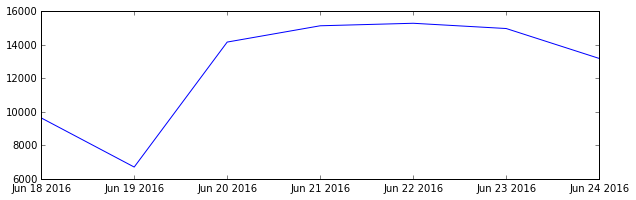

In [67]:
dates=[date for date, count in station_daily_tot[('STEINWAY ST')]]
counts=[count for date, count in station_daily_tot[('STEINWAY ST')]]
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

#Challenge 8

In [87]:
url='http://web.mta.info/developers/turnstile.html'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page)
data_files=[]
for link in soup.find_all('a'):
    link=(link.get('href'))
    dataset=re.findall('data/nyct/turnstile/turnstile_160[3-6][0-9][0-9].txt', str(link))
    if dataset!=[]:
        data_files.append('http://web.mta.info/developers/'+dataset[0])

In [89]:
data_files[::-1]

['http://web.mta.info/developers/data/nyct/turnstile/turnstile_160305.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160312.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160319.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160326.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160402.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160409.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160416.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160423.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160430.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160507.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160514.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160521.txt',
 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_160528.txt',
 'http://web

In [149]:
def master_mta_file2dict(mta_file):
    with open(mta_file,'rb') as csvfile:
        reader=csv.reader(csvfile)
        rows=[[cell.strip() for cell in row] for row in reader] #Remove whitespace

    rows.pop(0) #Remove 1st row which are essentially column names

    turnstile_dictionary = dict()
    for row in rows:
        key=tuple(row[1:5])
        if not turnstile_dictionary.has_key(key): #Initiate key if it does not exist
            turnstile_dictionary[key]=[]
        turnstile_dictionary[key].append(row[5:]) #Append information from row to dictionary value
    return turnstile_dictionary

In [151]:
#Here I was trying to just string together the previous sequence I had followed in earlier challenges,
#but having multiple information for specific turnstiles caused data to be overwritten.
#There were also many issues with load time. (This csv is 200+mb; is it normal to have a lot of lagging issues?)
mta_file='/Users/matthewmitchell/ds/metis/git/nyc16_ds8/challenges/challenges_solutions/MTA_2016Q2_Master.csv'
raw_dict=master_mta_file2dict(mta_file)

In [153]:
Q2_datetime_cum=turnstile_dict_2_cumulative_datetime(raw_dict)

In [154]:
Q2_datetime_counts=cumulative_datetime_2_frequency(Q2_datetime_cum)

In [155]:
Q2_datetime_counts=remove_implausible_counts(Q2_datetime_counts)

In [157]:
Q2_turnstile_daily_counts=turnstile_datetime_counts_2_turnstile_daily_counts(Q2_datetime_counts)

In [105]:
import glob
path = r'/Users/matthewmitchell/Downloads/MTA_Q2_2016/'         
all_files = glob.glob(path + "/*.txt")
big_df = pd.concat(pd.read_csv(f) for f in all_files)

In [131]:
big_df.to_csv('MTA_2016Q2_Master.csv')

In [296]:
#Test .isocalendar
june13='06/13/2016'
print datetime.date.today().isocalendar()
print datetime.datetime.strptime(june13,'%m/%d/%Y').isocalendar()

(2016, 28, 1)
(2016, 24, 1)


In [225]:
#Testing nesting dictionary syntax...
nested_dictionary={'station1':{'week1':{'M':1,'T':2,'W':3},'week2':{'M':4,'T':5,'W':6}}}
nested_dictionary.setdefault('station1',{'week1':{'Th':215}}) #does station 1 exist?
nested_dictionary['station1'].setdefault('week1',{'Th':215}) #does station 1, week 2 exist?
nested_dictionary['station1']['week1'].setdefault('Th',210) #does station 1, week 2, Th exist?

{'Th': 10}

In [226]:
#Create a nested dictionary of the form d={'station1':{'week1':{'M':[min,max],'T':[min,max],'W':[min,max]},'week2':{'M':[min,max],'T':[min,max],'W':[min,max]}}}
#Calls can be made as such dictionary['Station']['Week']['Day']
#Note that days are numbered 1-7 with 1 corresponding to Monday and 7 to Sunday
Q2_station_week_day_tot={}
mta_file='/Users/matthewmitchell/ds/metis/git/nyc16_ds8/challenges/challenges_solutions/MTA_2016Q2_Master.csv'
with open(mta_file,'rb') as csvfile:
        reader=csv.reader(csvfile)
        rows=[[cell.strip() for cell in row] for row in reader]
        for row in rows:
            station=row[4]
            entries=row[10]
            try:
                week=datetime.datetime.strptime(row[7],'%m/%d/%Y').isocalendar()[1]
                day=datetime.datetime.strptime(row[7],'%m/%d/%Y').isocalendar()[2]
                Q2_station_week_day_tot.setdefault(station, {week:{day:[entries,entries]}}) #Check if station exists, if not create entry
                Q2_station_week_day_tot[station].setdefault(week, {day:[entries,entries]}) #Check if station, week exists, if not create entry
                Q2_station_week_day_tot[station][week].setdefault(day, [entries,entries]) #Check if station, week, day exists, if not create entry
                if entries>Q2_station_week_day_tot[station][week][day][1]:
                    Q2_station_week_day_tot[station][week][day][1]=entries #is this entry greater than previous maximum for this station, week, day?
                elif entries<Q2_station_week_day_tot[station][week][day][0]:
                    Q2_station_week_day_tot[station][week][day][0]=entries #is this entry less than previous minimum for this sation, week, day?
                else:
                    continue
            except:
                continue

In [255]:
# Testing syntax...
# wk20=[(float(maximum)-float(minimum)) for minimum, maximum in Q2_station_week_day_tot['STEINWAY ST'][20].values()]
# wk20

[9531128.0, 9531559.0, 9531816.0, 9532133.0, 9532434.0, 9531997.0, 9531984.0]

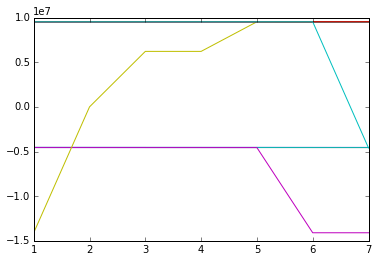

In [264]:
#Clearly using the Minimum/Maximum for a given day at a given station has caused some serious data errors...
for i in Q2_station_week_day_tot['STEINWAY ST'].keys()[1:-2]:
    wk=[(float(maximum)-float(minimum)) for minimum, maximum in Q2_station_week_day_tot['STEINWAY ST'][i].values()]
    plt.plot(range(1,8),wk)


In [257]:
wk14=[(float(maximum)-float(minimum)) for minimum, maximum in Q2_station_week_day_tot['STEINWAY ST'][14].values()]
wk14

[-4543050.0,
 -4543842.0,
 -4544345.0,
 -4545009.0,
 -4545693.0,
 -4547641.0,
 -4549122.0]

In [230]:
import pickle

with open('my_data.pkl', 'w') as picklefile:
    pickle.dump(Q2_station_week_day_tot, picklefile)

#Challenge 9

In [265]:
by_station=df.groupby('STATION')

In [283]:
df=df[df['STATION']!='STATION']

In [285]:
df['Net Difference']=df.groupby(['UNIT','SCP'])['ENTRIES'].diff()

ValueError: 

#I really want more help aggregating and cleaning datasets!
I continued having difficulty cleaning/processing this larger file so turned back to a single dataset.

In [55]:
data=pd.read_csv('/Users/matthewmitchell/Downloads/MTA_Q2_2016/turnstile_160402.txt')
data['NET_ENTRIES']=data.groupby(['UNIT','SCP'])['ENTRIES'].diff()
data['DATETIME']=data['DATE']+' '+data['TIME']
data['DATETIME']=pd.to_datetime(data['DATETIME'])

In [25]:
data.sort_index?

In [56]:
#Remove erroneous data
data=data[data['NET_ENTRIES']<5000]
data=data[data['NET_ENTRIES']>=0]

In [57]:
data.sort_index(by='NET_ENTRIES', ascending=False)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NET_ENTRIES,DATETIME
160547,R304,R206,00-00-03,125 ST,23,IRT,03/30/2016,08:01:22,REGULAR,374932,115251,4001,2016-03-30 08:01:22
160580,R304,R206,00-00-04,125 ST,23,IRT,03/30/2016,08:01:22,REGULAR,5423478,3021974,3992,2016-03-30 08:01:22
160691,R305,R206,01-00-02,125 ST,23,IRT,03/30/2016,17:00:00,RECOVR AUD,9164293,5889074,3561,2016-03-30 17:00:00
148840,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/28/2016,20:00:00,REGULAR,12277741,14200927,3411,2016-03-28 20:00:00
148864,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,04/01/2016,20:00:00,REGULAR,12315162,14209174,3401,2016-04-01 20:00:00
148858,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/31/2016,20:00:00,REGULAR,12304754,14207231,3273,2016-03-31 20:00:00
148846,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/29/2016,20:00:00,REGULAR,12286577,14202986,3208,2016-03-29 20:00:00
148852,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/30/2016,20:00:00,REGULAR,12295599,14205149,3187,2016-03-30 20:00:00
160620,R305,R206,01-00-00,125 ST,23,IRT,03/30/2016,17:00:00,RECOVR AUD,74405305,37859782,3127,2016-03-30 17:00:00
148776,R238,R046,00-00-09,GRD CNTRL-42 ST,4567S,IRT,04/01/2016,20:00:00,REGULAR,30470475,6876491,3066,2016-04-01 20:00:00


In [58]:
Net_Entries_by_station_and_time=data.groupby(['STATION','DATETIME'])['NET_ENTRIES'].sum()

In [59]:
Net_Entries_by_station_and_time=pd.DataFrame(Net_Entries_by_station_and_time)

In [63]:
ls

Amanda Gaudet Beyond the Bars Fellowship Cover Letter
Amanda Gaudet Beyond the Bars Fellowship Cover Letter.pdf
Chess Outline Feb22nd.pdf
GaudetAmandaCoverLetterBtBFellowship
GaudetAmandaCoverLetterBtBFellowship.pdf
GaudetAmandaResumeBtBFellowship
GaudetAmandaResumeBtBFellowship.pdf
Gaudet_Amanda_References  .pdf
Gaudet_Amanda_References.pdf
Gaudet_Amanda_Resume_private.pdf
Java 8 Update 60
Jon Kabat-Zinn
MTA_328_cleaned2.csv
MitchellResum.pdf
Percent_PercentChange.pdf
Photo on 6-25-15 at 10.57 AM
Problem Solving Period 3 & 7.docx
Screen Shot 2015-02-19 at 1.35.33 PM
Screen Shot 2015-05-14 at 10.09.04 PM
Screen Shot 2015-05-14 at 10.09.44 PM
Screen Shot 2015-05-17 at 8.59.25 AM
Screen Shot 2015-05-23 at 10.04.32 AM
Screen Shot 2015-08-20 at 1.53.03 PM
Stats+Data Exam Periods 1,2,8.pdf
Stats_Data_CC Unit Assessment.ps
Untitled
Walk 8-22-15
Wk 11 Raster and Remote Sensing/
WoodhullOPC_Gaudet_CoverLetter.pdf
Workbook1 (version 1).xlsx
Workbook1.xlsx
Workbook2 (version 1).xlsx


In [61]:
Net_Entries_by_station_and_time.to_csv('MTA_328_cleaned2.csv')

In [48]:
top30_place_times=Net_Entries_by_station_and_time.sort_index(by='NET_ENTRIES', ascending=False).head(30)

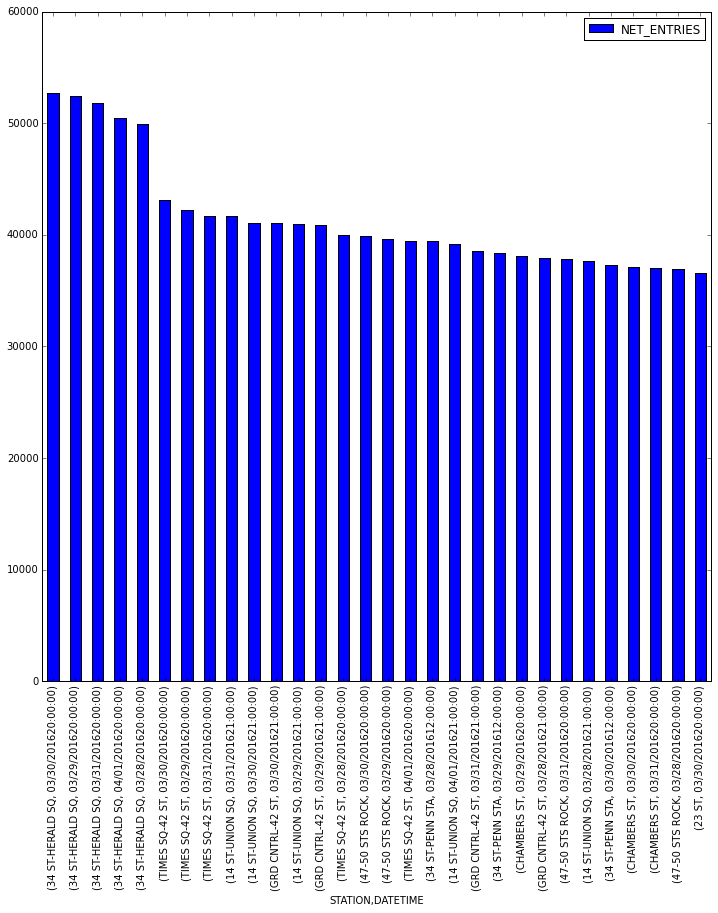

In [50]:
top30_place_times.plot(kind='bar', figsize=(12,12))

In [313]:
avg_by_time=data['NET_ENTRIES'].groupby([data['STATION'],data['LINENAME'],data['TIME']]).mean()
avg_by_time.head()

STATION  LINENAME  TIME    
1 AV     L         00:00:00    379.683333
                   04:00:00     99.385714
                   08:00:00    146.671429
                   09:25:33     90.200000
                   12:00:00    468.085714
Name: NET_ENTRIES, dtype: float64

In [314]:
df = data.groupby(['STATION','LINENAME','TIME']).mean()[['NET_ENTRIES']]
df25=df.sort(['NET_ENTRIES'], ascending=False).head(n=25)

In [315]:
df25

NET_ENTRIES
STATION         LINENAME TIME                 
125 ST          23       08:01:22       3996.5
PATH WTC        1        20:10:35       2110.0
                         20:12:57       1966.0
                         21:22:35       1947.0
                         20:03:15       1870.0
TWENTY THIRD ST 1        20:23:44       1840.0
PATH WTC        1        20:06:22       1834.0
TWENTY THIRD ST 1        21:45:15       1792.0
PATH WTC        1        18:58:35       1792.0
                         19:50:57       1788.0
                         20:47:57       1736.0
TWENTY THIRD ST 1        19:51:04       1734.0
PATH WTC        1        21:15:15       1731.0
                         21:24:57       1728.0
TWENTY THIRD ST 1        21:35:44       1726.0
PATH WTC        1        18:22:35       1720.0
                         19:35:57       1694.0
                         19:09:17       1677.0
                         19:18:22       1675.0
PAVONIA/NEWPORT 1        19:18:00       1671.0
JOURNAL SQUARE  1        10:47:50       1661.0
PATH WTC        1        20:10:36       1660.0
                         18:24:57       1656.0
PAVONIA/NEWPORT 1        10:54:00       1633.0
CITY / BUS      1        09:42:02       1563.0

#Challenge 10

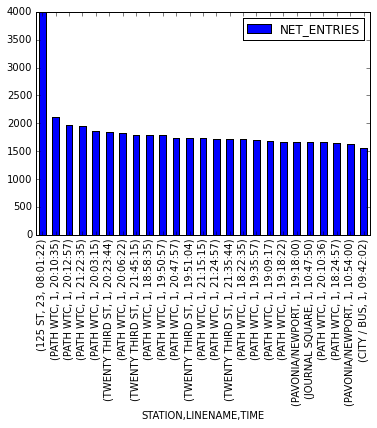

In [316]:
df25.plot(kind='bar')

In [19]:
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,NET_ENTRIES,DATETIME
14,A002,R051,02-00-00,59 ST,NQR456,BMT,03/28/2016,08:00:00,REGULAR,5595780,1893382,34,03/28/201608:00:00
15,A002,R051,02-00-00,59 ST,NQR456,BMT,03/28/2016,12:00:00,REGULAR,5595936,1893679,156,03/28/201612:00:00
16,A002,R051,02-00-00,59 ST,NQR456,BMT,03/28/2016,16:00:00,REGULAR,5596182,1893748,246,03/28/201616:00:00
17,A002,R051,02-00-00,59 ST,NQR456,BMT,03/28/2016,20:00:00,REGULAR,5596691,1893934,509,03/28/201620:00:00
18,A002,R051,02-00-00,59 ST,NQR456,BMT,03/29/2016,00:00:00,REGULAR,5596896,1893974,205,03/29/201600:00:00


In [7]:
data['Date_time']=data.DATE+data.TIME

In [12]:
data=data.drop('Date_time', axis=1)

In [15]:
pd.to_datetime(data.DATETIME)

14        03/28/201608:00:00
15        03/28/201612:00:00
16        03/28/201616:00:00
17        03/28/201620:00:00
18        03/29/201600:00:00
19        03/29/201604:00:00
20        03/29/201608:00:00
21        03/29/201612:00:00
22        03/29/201616:00:00
23        03/29/201620:00:00
24        03/30/201600:00:00
25        03/30/201604:00:00
26        03/30/201608:00:00
27        03/30/201612:00:00
28        03/30/201616:00:00
29        03/30/201620:00:00
30        03/31/201600:00:00
32        03/31/201608:00:00
33        03/31/201609:22:41
36        03/31/201620:00:00
37        04/01/201600:00:00
38        04/01/201604:00:00
39        04/01/201608:00:00
40        04/01/201612:00:00
41        04/01/201616:00:00
42        04/01/201620:00:00
57        03/28/201608:00:00
58        03/28/201612:00:00
59        03/28/201616:00:00
60        03/28/201620:00:00
                 ...        
194044    03/28/201613:00:00
194045    03/28/201617:00:00
194046    03/28/201621:00:00
194047    03/2

In [18]:
data.DATETIME

14        03/28/201608:00:00
15        03/28/201612:00:00
16        03/28/201616:00:00
17        03/28/201620:00:00
18        03/29/201600:00:00
19        03/29/201604:00:00
20        03/29/201608:00:00
21        03/29/201612:00:00
22        03/29/201616:00:00
23        03/29/201620:00:00
24        03/30/201600:00:00
25        03/30/201604:00:00
26        03/30/201608:00:00
27        03/30/201612:00:00
28        03/30/201616:00:00
29        03/30/201620:00:00
30        03/31/201600:00:00
32        03/31/201608:00:00
33        03/31/201609:22:41
36        03/31/201620:00:00
37        04/01/201600:00:00
38        04/01/201604:00:00
39        04/01/201608:00:00
40        04/01/201612:00:00
41        04/01/201616:00:00
42        04/01/201620:00:00
57        03/28/201608:00:00
58        03/28/201612:00:00
59        03/28/201616:00:00
60        03/28/201620:00:00
                 ...        
194044    03/28/201613:00:00
194045    03/28/201617:00:00
194046    03/28/201621:00:00
194047    03/2